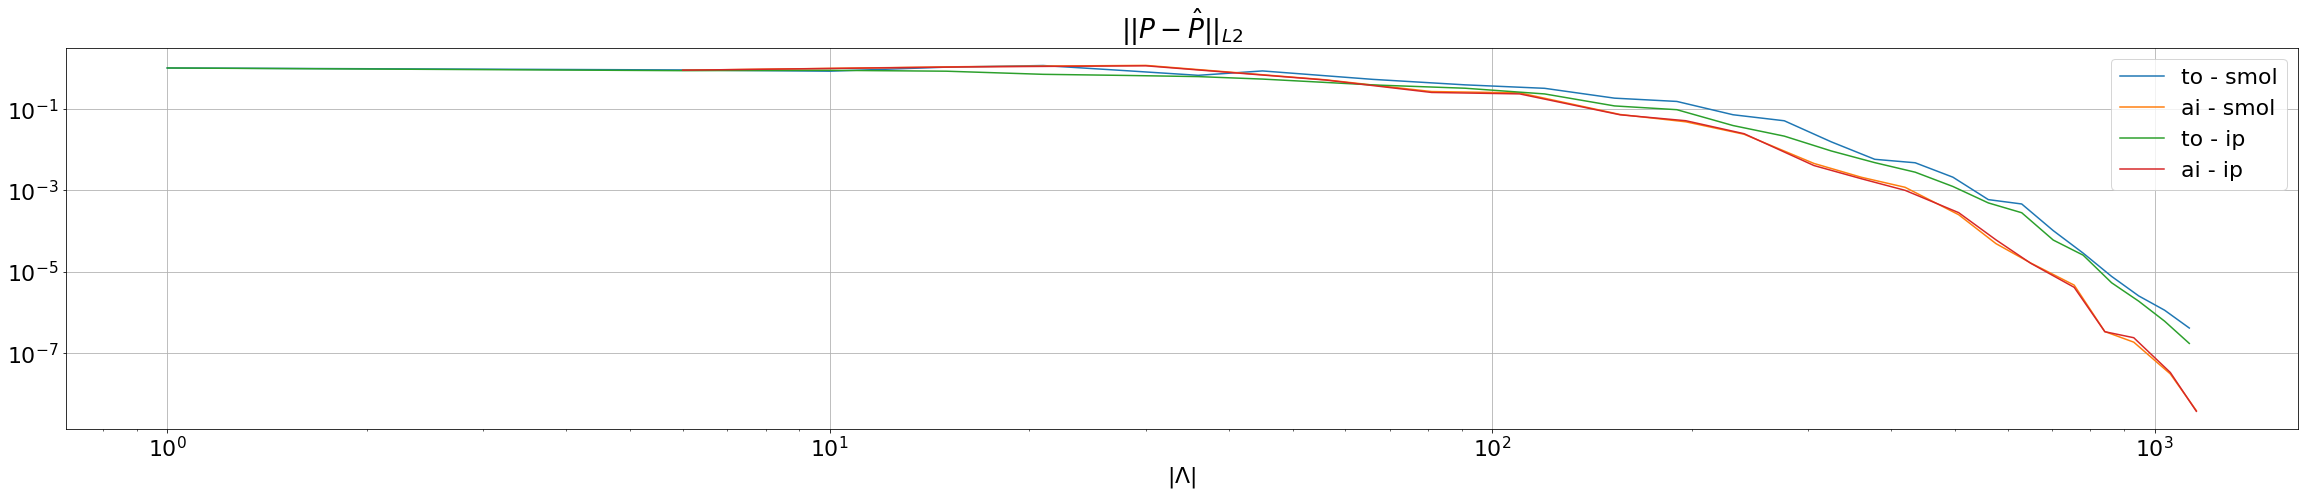

In [2]:
import sys, time, cProfile, pstats, importlib, os, re
sys.path.insert(0,'/home/uq/apps/muq2inst/lib')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tikzplotlib

from scipy.special import legendre
from scipy.stats import rv_continuous
from numpy.polynomial.legendre import legvander, leggauss
from numpy.polynomial import polyutils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 7.)
matplotlib.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D

import pymuqUtilities as mu

import testutil, plotutil, legendreutil, indexutil, lejautil, basis
from TransportMap import TransportMap
importlib.reload(mu)

from Convolution import Convolution

def print_multiset(multiset) :
    print('Multiset ({} indices): '.format(len(multiset.GetAllMultiIndices())))
    for m in multiset.GetAllMultiIndices() : print(m.GetVector(), end=' ')
    print()
    
    
from database import *

def plot_single(ax, dbo_arr, get_x, get_y, kwargs) :
    for i in range(len(dbo_arr)) :
        x = [get_x(dbo) for dbo in dbo_arr[i]]
        y = [get_y(dbo) for dbo in dbo_arr[i]]
        ax.plot(x, y, **kwargs[i])
    ax.legend()

evals = PceEvaluation.select().join(PceCalculation).join(Multiset).switch(PceCalculation).join(Measurement).join(Parameter).join(Model)

evals = [evals.where(Multiset.stype == 'totalorder').where(PceCalculation.methd == 'smolyak'), 
         evals.where(Multiset.stype == 'anisotropic').where(PceCalculation.methd == 'smolyak'), 
         evals.where(Multiset.stype == 'totalorder').where(PceCalculation.methd == 'ip'), 
         evals.where(Multiset.stype == 'anisotropic').where(PceCalculation.methd == 'ip')]

kwargs = [{'label' : 'to - smol'},
          {'label' : 'ai - smol'},
          {'label' : 'to - ip'},
          {'label' : 'ai - ip'}]


get_x = lambda dbo : dbo.calc.multi.size
get_y = lambda dbo : dbo.l2dst
get_kwargs = lambda dbo : dict()

ax = plotutil.get_ax(plt.figure(), 1, 1, title=r'$||P - \hat{P}||_{L2}$', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
plot_single(ax, evals, get_x, get_y, kwargs)

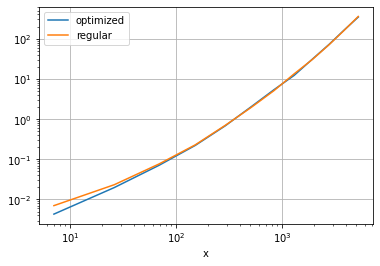

In [4]:
import matplotlib.pyplot as plt
from plotutil import *

Size = [7, 26, 69, 151, 291, 511, 838, 1301, 1933, 2772, 3858, 5236]
Time1 = [0.00432471, .0197837, .0710167, .220589, .682652, 2.03225, 5.37993, 12.2598, 31.0657, 71.8669,164.456,344.805]
Time2 = [0.0070302, 0.0232934, 0.0766878, 0.22794, 0.700825, 1.95546, 5.10361, 13.3797, 30.4853, 70.5407, 161.866, 357.163]


ax = get_ax(plt.figure(), 1, 1, logaxis=['x', 'y'])
ax.plot(Size, Time1, label="optimized")
ax.plot(Size, Time2, label="regular")
ax.legend()
plt.show()

In [2]:
def load_p_m_coeffs(*, d=2, p=1, sigma=.1, m=1, basis_type='hats', alpha=1, set_type='order', order_eps='8', appr='wls') :
    data_dir = 'data_conv_{}_alpha={}/d={}/p={}/'.format(basis_type, alpha, d, p)
    p = np.loadtxt(data_dir+'param.csv', delimiter=',')
    data_dir += 's={}/m={}/'.format(sigma, m)
    x_meas = np.loadtxt(data_dir+'x_meas.csv', delimiter=',')
    y_meas = np.loadtxt(data_dir+'y_meas.csv', delimiter=',')
    filename = '{}={}_{}_coeffs.csv'.format(set_type, order_eps, appr)
    coeffs = np.loadtxt(data_dir+filename, delimiter=',')
    return p, x_meas, y_meas, coeffs

# Convolution of a series expansion

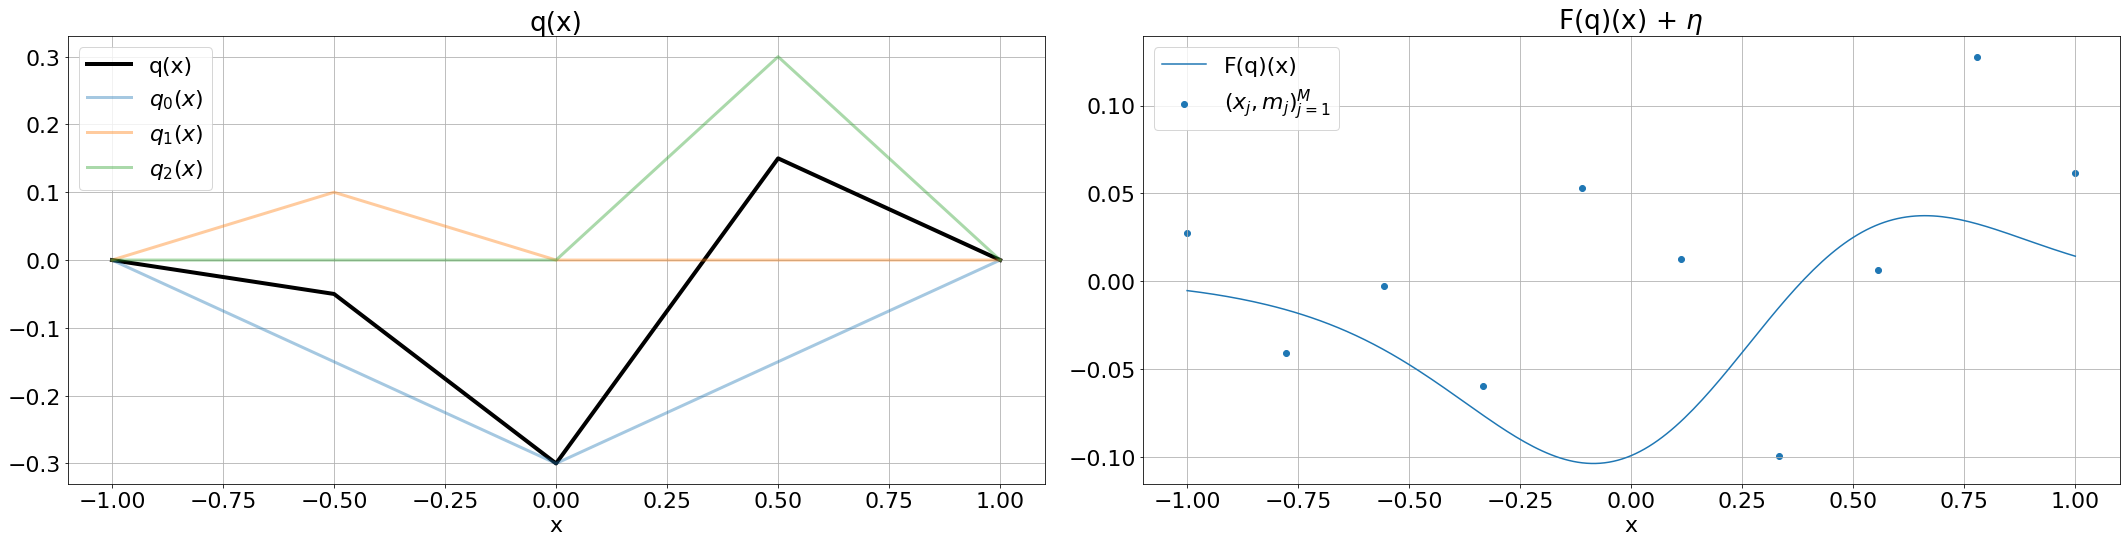

In [19]:
x_meas = np.linspace(-1,1,10)
x_eval = np.linspace(-1,1,201)
param  = [-.3,.2,.6]
noise = .1
d = len(param)
q = basis.hats
alpha = 1

F_x_meas = Convolution(basis=q, d=d, alpha=alpha, x_measurement=x_meas).Evaluate([param])[0] + noise*np.random.randn(len(x_meas))
F_x_eval = Convolution(basis=q, d=d, alpha=alpha, x_measurement=x_eval).Evaluate([param])[0]

fig = plt.figure(figsize=(30,8))
ax = plotutil.get_ax(fig, 2, 1, title='q(x)')
ax.plot(x_eval, [q(xi, param, alpha) for xi in x_eval], 'k', lw=4, label='q(x)')
for i in range(len(param)) :
    ax.plot(x_eval, [q(xi, [0]*i + [param[i]], alpha) for xi in x_eval], lw=3, label=r'$q_{}(x)$'.format(i), alpha=.4)
ax.legend()
ax = plotutil.get_ax(fig, 2, 2, title=r'F(q)(x) + $\eta$')
ax.plot(x_eval, F_x_eval, label='F(q)(x)')
ax.scatter(x_meas, F_x_meas, label=r'$(x_j, m_j)_{j=1}^M$')
ax.legend()
plt.tight_layout()

if False :
    filename = '../../overview/figures/alpha={}/target_and_convolution_{}d.'.format(alpha, d)
    plt.savefig(filename+'pdf', format='pdf')
    tikzplotlib.save(filename+'tex')

# Convergence

In [67]:

evals = (PceEvaluation.select().join(PceCalculation).join(Multiset)
                               .switch(PceCalculation).join(Measurement).join(Parameter).join(Model)
                               .where(Model.mtype == 'convolution' and Model.dim == 2 and Model.basis == 'hats' and Model.alpha == 1 and Model.noise == .1)
                               .where(Parameter.p_id == 1)
                               .where(Measurement.m_id == 1)
                               .where(Multiset.stype == 'anisotropic')
                               .where(PceCalculation.methd == 'smolyak')
                               .where(PceEvaluation.methd == 'mc'))
evals = evals.where(Multiset.stype == 'anisotropic' and Multiset.alpha == 1 and Multiset.epsln == .1)
for ev in evals :
    print(ev.calc.msrmt.param.model.mtype)

convolution
convolution


In [85]:
from run import *

class Args() :
    def __init__(self) :
        self.model = 'convolution'
        self.d = 2
        self.p = 1
        self.m = 1
        self.basis = 'hats'
        self.appr = 'smolyak'
        self.int = 'mc'
        self.sigma = .1
        self.alpha = 1
        self.stype = 'totalorder'
        self.order = 0
        self.eps = .1
        self.cpu_count = 4
        
evalDBO = create_data(Args())



[INFO_ISO_d=2_a=1_o=0_smolyak] Creating multiset... 

OperationalError: attempt to write a readonly database

In [82]:
args

NameError: name 'args' is not defined

data_conv_hats_alpha=1
data_conv_hats_alpha=2
data_conv_hats_alpha=4
data_conv_hats_alpha=8


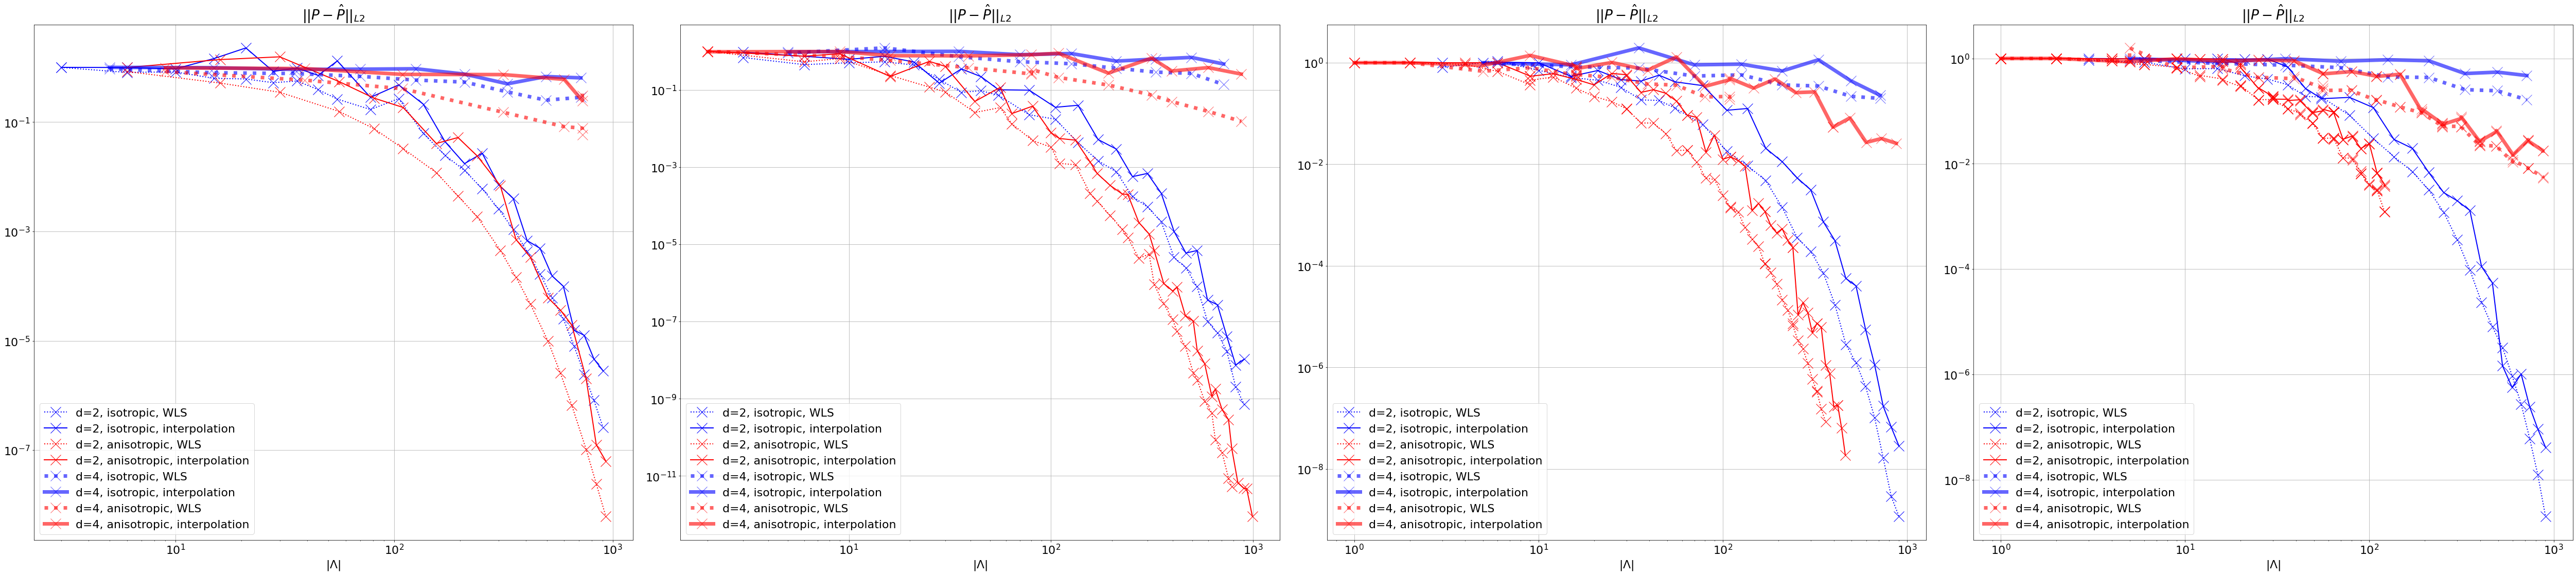

In [4]:
fig =  plt.figure(figsize=(70,16))
ls = {'ip' : '-', 'ls' : '-.', 'wls' : ':'}
cc = {'order' : 'b', 'eps' : 'r'}
al = {'d=2' : 1, 'd=4' : .6, 'd=8' : .3, 'd=16' : .1, }
lw = {'d=2' : 2, 'd=4' : 7, 'd=8' : 13, 'd=16' : 18}
set_type_mapped = {'order' : 'isotropic', 'eps' : 'anisotropic'}
appr_mapped = {'ip' : 'interpolation', 'wls' : 'WLS', 'ls': 'LS'}

basis_type = 'hats'
alphas = [1,2,4,8]
for i in range(len(alphas)) :
    
    ax = plotutil.get_ax(fig, 4, i+1, title=r'$||P - \hat{P}||_{L2}$', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    data_dir = 'data_conv_{}_alpha={}'.format(basis_type, alphas[i])
    print(data_dir)
    for dim_dir in ['d=2', 'd=4'] : #sorted(os.listdir(data_dir)) :
        for param_dir in os.listdir(data_dir+'/'+dim_dir) :
            for sigma_dir in ['s=0.1'] : #[x for x in os.listdir(data_dir+'/'+dim_dir+'/'+param_dir) if re.match('s=*', x)] :
                for m_dir in ['m=1']: #os.listdir(data_dir+'/'+dim_dir+'/'+param_dir+'/'+sigma_dir) :
                    for set_type in ['order', 'eps'] :
                        for appr in ['ls', 'wls', 'ip'] :
                            for intg in ['mc'] :
                                lambdas, l2 = load_results(d=int(dim_dir.split('=')[1]), p=int(param_dir.split('=')[1]), sigma=float(sigma_dir.split('=')[1]), m=int(m_dir.split('=')[1]), basis_type=basis_type, alpha=alphas[i], set_type=set_type, appr=appr, intg=intg)
                                if lambdas is not None :
                                    if m_dir == 'm=1' :
                                        ax.plot(lambdas, l2, marker='x', ms=20, ls=ls[appr], alpha=al[dim_dir], color=cc[set_type], linewidth=lw[dim_dir],
                                                 label='{}, {}, {}'.format(dim_dir, set_type_mapped[set_type], appr_mapped[appr]))

    ax.legend()

plt.tight_layout()

if False :
    filename = '../../overview/figures/alpha={}/l2_convergence.'.format(alpha)
    plt.savefig(filename+'pdf', format='pdf')

data_conv_steps_alpha=1
data_conv_steps_alpha=2
data_conv_steps_alpha=4
data_conv_steps_alpha=8


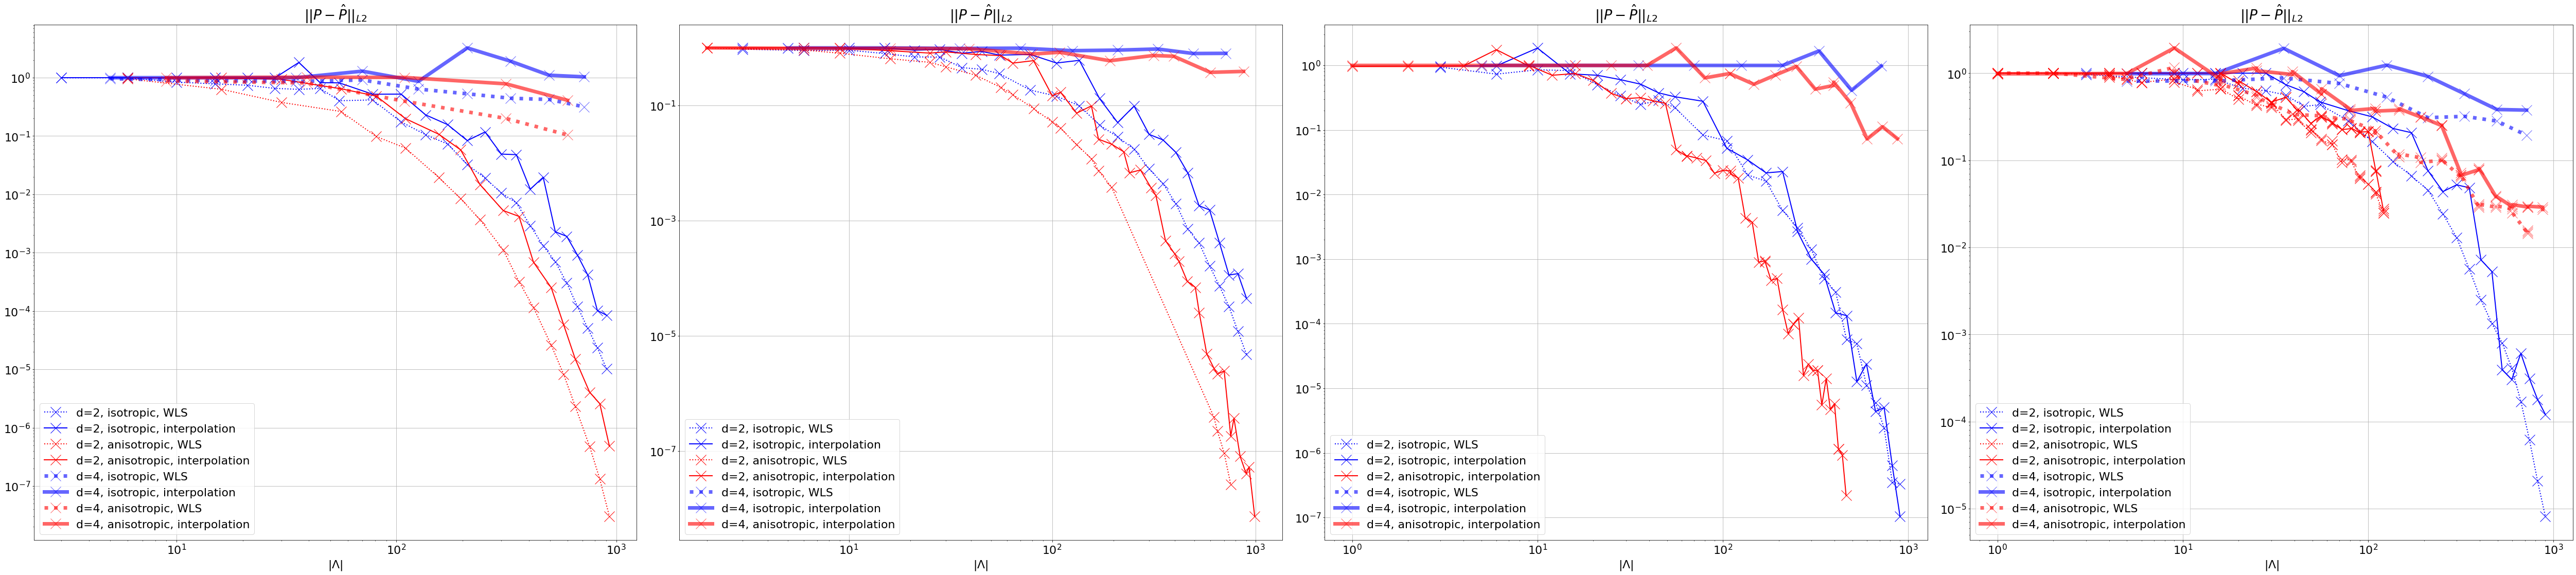

In [5]:
fig =  plt.figure(figsize=(70,16))
basis_type = 'steps'
alphas = [1,2,4, 8]
for i in range(len(alphas)) :
    
    ax = plotutil.get_ax(fig, 4, i+1, title=r'$||P - \hat{P}||_{L2}$', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    data_dir = 'data_conv_{}_alpha={}'.format(basis_type, alphas[i])
    print(data_dir)
    for dim_dir in ['d=2', 'd=4'] : #sorted(os.listdir(data_dir)) :
        for param_dir in os.listdir(data_dir+'/'+dim_dir) :
            for sigma_dir in ['s=0.1'] : #[x for x in os.listdir(data_dir+'/'+dim_dir+'/'+param_dir) if re.match('s=*', x)] :
                for m_dir in ['m=1']: #os.listdir(data_dir+'/'+dim_dir+'/'+param_dir+'/'+sigma_dir) :
                    for set_type in ['order', 'eps'] :
                        for appr in ['ls', 'wls', 'ip'] :
                            for intg in ['mc'] :
                                lambdas, l2 = load_results(d=int(dim_dir.split('=')[1]), p=int(param_dir.split('=')[1]), sigma=float(sigma_dir.split('=')[1]), m=int(m_dir.split('=')[1]), basis_type=basis_type, alpha=alphas[i], set_type=set_type, appr=appr, intg=intg)
                                if lambdas is not None :
                                    if m_dir == 'm=1' :
                                        ax.plot(lambdas, l2, marker='x', ms=20, ls=ls[appr], alpha=al[dim_dir], color=cc[set_type], linewidth=lw[dim_dir],
                                                 label='{}, {}, {}'.format(dim_dir, set_type_mapped[set_type], appr_mapped[appr]))

    ax.legend()

plt.tight_layout()

if False :
    filename = '../../overview/figures/alpha={}/l2_convergence.'.format(alpha)
    plt.savefig(filename+'pdf', format='pdf')

data_conv_hats_cdec_alpha=1
data_conv_hats_cdec_alpha=2
data_conv_hats_cdec_alpha=4
data_conv_hats_cdec_alpha=8


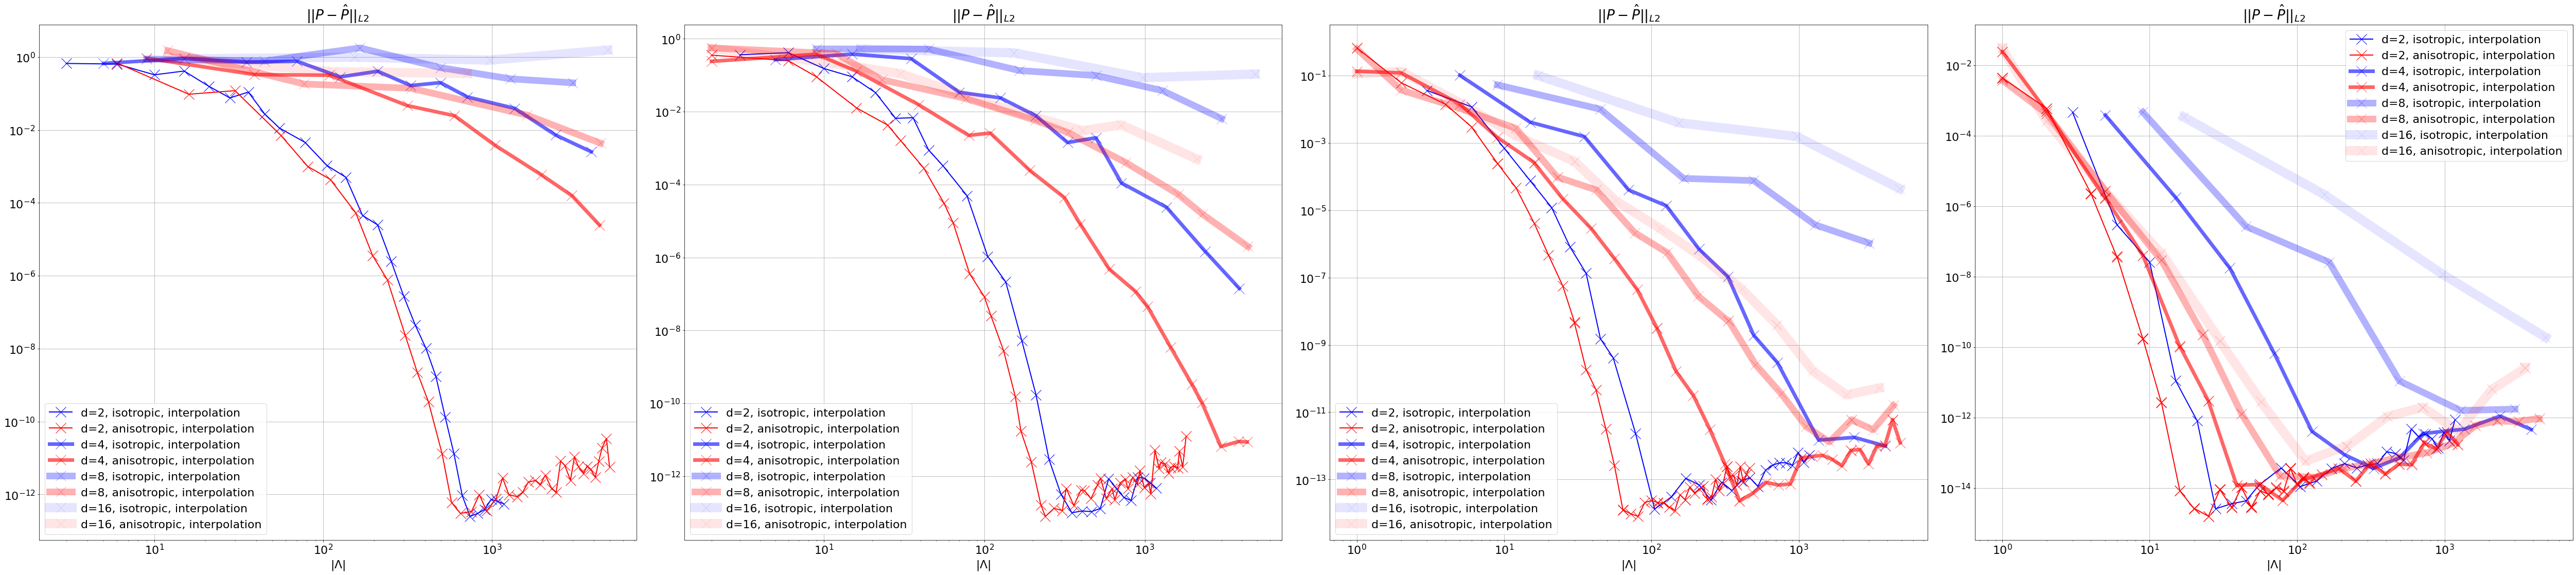

In [6]:
fig =  plt.figure(figsize=(70,16))
basis_type = 'hats_cdec'
alphas = [1,2,4, 8]
for i in range(len(alphas)) :
    
    ax = plotutil.get_ax(fig, 4, i+1, title=r'$||P - \hat{P}||_{L2}$', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    data_dir = 'data_conv_{}_alpha={}'.format(basis_type, alphas[i])
    print(data_dir)
    for dim_dir in ['d=2', 'd=4', 'd=8', 'd=16'] : #sorted(os.listdir(data_dir)) : #
        for param_dir in os.listdir(data_dir+'/'+dim_dir) :
            for sigma_dir in [x for x in os.listdir(data_dir+'/'+dim_dir+'/'+param_dir) if re.match('s=*', x)] :
                for m_dir in os.listdir(data_dir+'/'+dim_dir+'/'+param_dir+'/'+sigma_dir) :
                    for set_type in ['order', 'eps'] :
                        for appr in ['ls', 'wls', 'ip'] :
                            for intg in ['mc'] :
                                lambdas, l2 = load_results(d=int(dim_dir.split('=')[1]), p=int(param_dir.split('=')[1]), sigma=float(sigma_dir.split('=')[1]), m=int(m_dir.split('=')[1]), basis_type=basis_type, alpha=alphas[i], set_type=set_type, appr=appr, intg=intg)
                                if lambdas is not None :
                                    if m_dir == 'm=1' :
                                        ax.plot(lambdas, l2, marker='x', ms=20, ls=ls[appr], alpha=al[dim_dir], color=cc[set_type], linewidth=lw[dim_dir],
                                                 label='{}, {}, {}'.format(dim_dir, set_type_mapped[set_type], appr_mapped[appr]))

    ax.legend()

plt.tight_layout()

if False :
    filename = '../../overview/figures/alpha={}/l2_convergence.'.format(alpha)
    plt.savefig(filename+'pdf', format='pdf')

In [64]:
target = lambda p : P(x_meas, m_x_meas, p, sigma)
p_grid = get_d_dim_grid_points(d)

l2_total_leja = [l2_distance(target, multisets_total[i], coeffs_total_leja[i], p_grid) for i in range(len(multisets_total))]
#l2_total_lstsq = [l2_distance(target, multisets_total[i], coeffs_total_lstsq[i], p_grid) for i in range(len(multisets_total))]
l2_dimad_leja = [l2_distance(target, multisets_dimad[i], coeffs_dimad_leja[i], p_grid) for i in range(len(multisets_dimad))]
#l2_dimad_lstsq = [l2_distance(target, multisets_dimad[i], coeffs_dimad_lstsq[i], p_grid) for i in range(len(multisets_dimad))]

In [113]:
def expectation(multiset, coeffs, p_grid, d) :
    transport = TransportMap(d, coeffs, multiset)
    p_grid_mapped = [transport.inverse_evaluate(p_grid[i]) for i in range(p_grid.shape[0])]
    print('\t', np.min(p_grid_mapped), np.max(p_grid_mapped))
    exp = np.mean(p_grid_mapped, axis=0)
    print('\t', exp)
    return exp

In [136]:
mesh = np.linspace(-1, 1, 20, endpoint=True)
X_grid, Y_grid = np.meshgrid(mesh, mesh)
X_sampled = np.vstack((np.ndarray.flatten(X_grid), np.ndarray.flatten(Y_grid)))

In [119]:
expected_p_4 = 0
p_norm = 0
for i in range(p_grid.shape[0]) :
    post = problem.P(x_meas, y_meas, q, p_grid[i], sigma, alpha)
    expected_p_4 += post * p_grid[i]
    p_norm += post
expected_p_4 /= p_norm

[-0.98385925  0.62444806  0.72935764 -0.86043561]


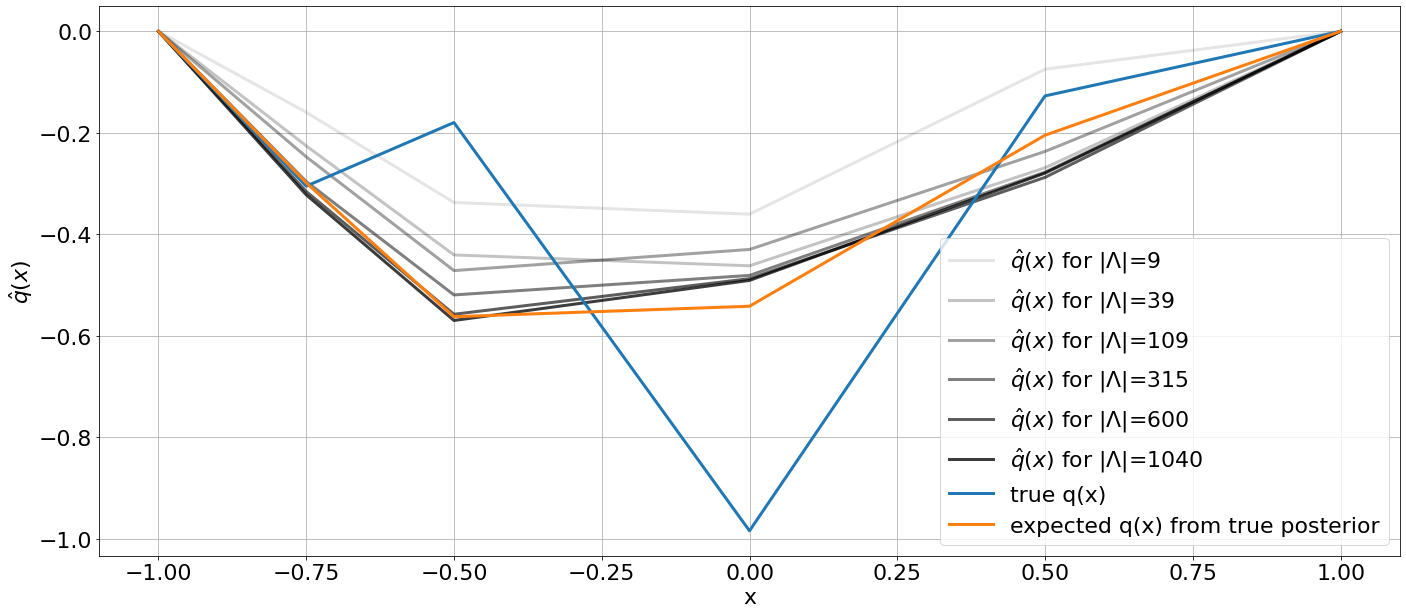

In [123]:
print(p)
q = basis.hats
fig = plt.figure(figsize=(20,9))
ax = plotutil.get_ax(fig, 1, 1, title='', ylabel=r'$\hat{q}(x)$')
for i in range(len(expts)) : 
    ax.plot(x_grid, [q(xi, expts[i], alpha) for xi in x_grid], 'k', alpha=.1+.8*i/len(expts), label=r'$\hat{q}(x)$' + ' for $|\Lambda|$={}'.format(int(lambdas[i])), lw=3)
ax.plot(x_grid, [q(xi, p, alpha) for xi in x_grid], label='true q(x)',  lw=3)
ax.plot(x_grid, [q(xi, expected_p_4, alpha) for xi in x_grid], label='expected q(x) from true posterior',  lw=3)
ax.legend()
plt.tight_layout()

if True :
    filename = '../../overview/figures/alpha={}/expectation_{}d.'.format(alpha, d)
    plt.savefig(filename+'pdf', format='pdf')

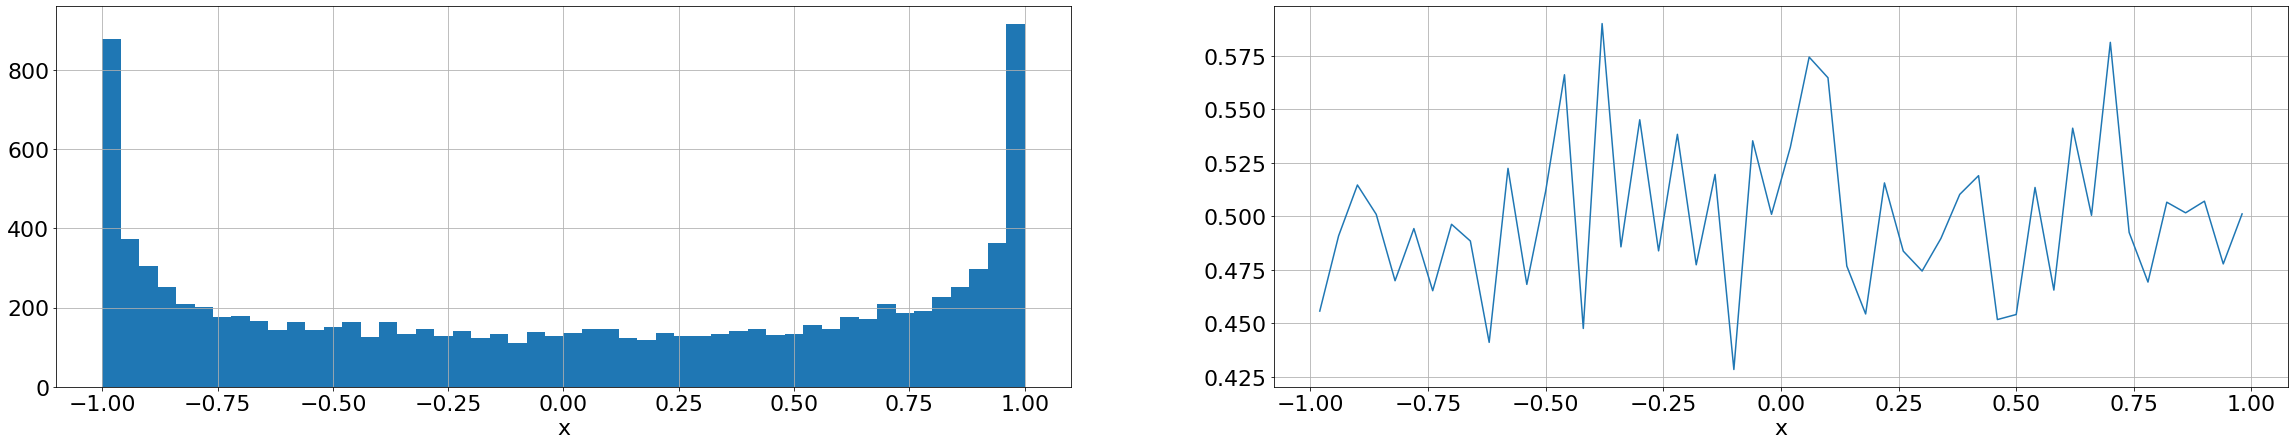

In [31]:
samples = np.sin(np.random.uniform(low=-3*np.pi/2, high=np.pi/2, size=(10000,)))
hist, edges = np.histogram(samples, weights=[np.pi * np.sqrt(1-x**2) / 2 for x in samples], bins=50, density=True )

fig = plt.figure()
ax = plotutil.get_ax(fig, 2, 1)
ax.hist(samples, bins=50)
ax = plotutil.get_ax(fig, 2, 2)
ax.plot((edges[:-1] + edges[1:])/2, hist)
plt.show()

In [2]:
import lejautil

<ipython-input-3-ff3e8086d583>:14: RuntimeWarning: invalid value encountered in true_divide
  betas[k] = (2 * k + 1)/(n*(n+1)) * np.sum([L[k](points[j]) * f_points[j] / (L[-1](points[j])**2) for j in range(n)])


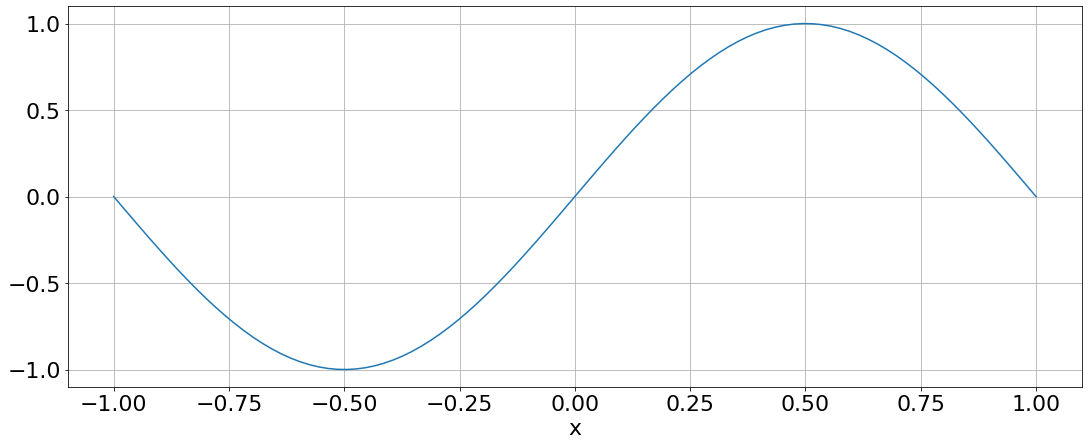

In [3]:
def f(x) :
    return np.sin(x*np.pi) 
x = np.linspace(-1,1,100)
f_x = [f(xi) for xi in x]

n = 4
L = [legendre(i) for i in range(n)] # *np.sqrt((2*i + 1)/2)

points = lejautil.leja_points_1d(n)
f_points = [f(pi) for pi in points]

betas = np.zeros((n,))
for k in range(n) :
    betas[k] = (2 * k + 1)/(n*(n+1)) * np.sum([L[k](points[j]) * f_points[j] / (L[-1](points[j])**2) for j in range(n)])
    
inter = [np.sum([betas[k] * L[k](xi) for k in range(n)]) for xi in x]


fig = plt.figure()
ax = plotutil.get_ax(fig, 2, 1)
ax.plot(x, f_x)
ax.plot(x, inter)
plt.show()